In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing dependencies

import numpy as np
np.random.seed(1)

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import keras
plt.style.use('ggplot')
from keras.layers import Dense, Dropout

In [3]:
# Loading the dataset
#Note you need to upload the dataset here 
df = pd.read_csv("/content/drive/My Drive/Dissertation/Fundy/stockCATT.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-25,246.0,246.0,238.0,1850.0,216.190476,219.641297,34.0,67.266588,17.821782,9.627825,216.6,8.282992e+05,80.952381,85.807656,238.0
2014-06-26,228.0,238.0,228.0,21110.0,214.476190,217.805426,28.0,66.497705,13.461538,9.214435,215.1,9.957417e+05,94.117647,92.156863,236.0
2014-06-30,234.0,234.0,232.0,1500.0,213.142857,215.985969,22.0,64.928560,12.621359,8.756407,213.4,1.147855e+06,82.352941,92.156863,232.0
2014-07-02,224.0,238.0,224.0,17000.0,211.904762,214.384566,34.0,69.584450,14.423077,8.451703,212.2,1.319687e+06,100.000000,98.039216,238.0
2014-07-03,228.0,228.0,228.0,25000.0,210.476190,212.023022,22.0,65.677831,9.615385,7.328948,210.6,1.019886e+06,94.117647,89.705882,228.0


In [4]:
# Extracting the close feature of the series
predictStockCATTClose = df[['Close']]
print(predictStockCATTClose.shape)
predictStockCATTClose.head()

(1053, 1)


,Close
Date,
2014-06-25,238.0
2014-06-26,236.0
2014-06-30,232.0
2014-07-02,238.0
2014-07-03,228.0


In [5]:
# Split the historical close stock prices into train and test datasets (1008 Historical Close Stock Prices for Training and 45 Historiacal Close Stock Prices for Testing )
train = predictStockCATTClose['2014-06-15':'2020-03-01'].sort_index(ascending='True')
test = predictStockCATTClose['2020-03-02':'2020-06-14'].sort_index(ascending='True')

In [6]:
# Use the MinMaxScaler to scale the data within the range 0-1
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [7]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [8]:
trainingSet = scaled_train
validationSet = scaled_test

In [ ]:
# Initialise the early stopping for the LSTM
early_stop = EarlyStopping(monitor = 'loss',patience = 5)

# Define the epochs parameters
epochs = [1, 10, 50]

# Define the batch_size parameters
batchs = [1, 8, 16]

# Define the number of days features parameters
features = [25, 30, 45]

# Define the lstm_units parameters
units = [10, 50, 64]

# Define the dropout_prob parameters
dropouts = [0.3, 0.5, 0.7]

evaluation = []

for epoch in epochs:
    for batch in batchs:
        for feature in features:
            for unit in units:
                for dropout in dropouts:

                    # Convert the training dataset into x_trainingSet and y_trainingSet array
                    x_trainingSet, y_trainingSet = [], []
                    for i in range(feature,len(trainingSet)):
                        x_trainingSet.append(trainingSet[i-feature:i,0])
                        y_trainingSet.append(trainingSet[i,0])
                    x_trainingSet, y_trainingSet = np.array(x_trainingSet), np.array(y_trainingSet)

                    x_trainingSet = np.reshape(x_trainingSet, (x_trainingSet.shape[0],x_trainingSet.shape[1],1))

                    # Instantiate and fit the LSTM Network
                    lstmodel = Sequential()
                    lstmodel.add(LSTM(units=unit, return_sequences=True, input_shape=(x_trainingSet.shape[1],1)))
                    lstmodel.add(Dropout(dropout))
                    lstmodel.add(LSTM(units=unit))
                    lstmodel.add(Dropout(dropout))
                    lstmodel.add(Dense(1))

                    lstmodel.compile(loss='mean_squared_error', optimizer='adam')
                    lstmodel.fit(x_trainingSet, y_trainingSet, epochs=epoch, batch_size=batch, verbose=0, callbacks = [early_stop])

                    #predicting 251 values, using past no of days in the feature parameter from the trainingSet data
                    inputs = predictStockCATTClose[len(predictStockCATTClose) - len(validationSet) - feature:].values
                    inputs = inputs.reshape(-1,1)
                    inputs  = scaler.transform(inputs)

                    X_validationSet = []
                    for i in range(feature,inputs.shape[0]):
                        X_validationSet.append(inputs[i-feature:i,0])
                    X_validationSet = np.array(X_validationSet)

                    X_validationSet = np.reshape(X_validationSet, (X_validationSet.shape[0],X_validationSet.shape[1],1))
                    preds = lstmodel.predict(X_validationSet)
                    preds = scaler.inverse_transform(preds)

                    test['PredClose'] = preds
                    groundtruth = test['Close'].to_numpy()
                    predictions = test['PredClose'].to_numpy()
                    mae = mean_absolute_error(groundtruth, predictions)
                    mape = np.mean(np.abs((groundtruth, predictions) / groundtruth)) * 100
                    mse = mean_squared_error(groundtruth, predictions)
                    rmse = np.sqrt(mean_squared_error(groundtruth, predictions))
                    # append the LSTM parameters and evaluation matrics in a list [Epochs, Batch Size, Number of Features, LSTM Units, Dropout List, MAE, MAPE, MSE, RMSE]
                    evaluation.append([epoch, batch, feature, unit, dropout, mae, mape, mse, rmse])

In [ ]:
evaluation

In [9]:
# Declare the n_features and batch variables and initialise early stopping for the LSTM
# Initialise the early stopping for the LSTM
early_stop = EarlyStopping(monitor = 'loss',patience = 5)

# Define the epochs parameter
epochs = 50

# Define the batch_size parameter
batch = 1

# Define the number of days features parameters
n_features = 45

# Define the lstm_units parameters
lstm_units = 50

# Define the dropout_prob parameters
dropout = 0.3

# Convert the training dataset into x_trainingSet and y_trainingSet array
x_trainingSet, y_trainingSet = [], []
for i in range(n_features,len(trainingSet)):
    x_trainingSet.append(trainingSet[i-n_features:i,0])
    y_trainingSet.append(trainingSet[i,0])
x_trainingSet, y_trainingSet = np.array(x_trainingSet), np.array(y_trainingSet)

x_trainingSet = np.reshape(x_trainingSet, (x_trainingSet.shape[0],x_trainingSet.shape[1],1))

# Instantiate and fit the LSTM Network
lstmodel = Sequential()
lstmodel.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_trainingSet.shape[1],1)))
lstmodel.add(Dropout(dropout))
lstmodel.add(LSTM(units=lstm_units))
lstmodel.add(Dropout(dropout))
lstmodel.add(Dense(1))

lstmodel.compile(loss='mean_squared_error', optimizer='adam')
lstmodel.fit(x_trainingSet, y_trainingSet, epochs=epochs, batch_size=batch, verbose=0, callbacks = [early_stop])

#predicting 251 values, using past no of days in the feature parameter from the trainingSet data
inputs = predictStockCATTClose[len(predictStockCATTClose) - len(validationSet) - n_features:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_validationSet = []
for i in range(n_features,inputs.shape[0]):
    X_validationSet.append(inputs[i-n_features:i,0])
X_validationSet = np.array(X_validationSet)

X_validationSet = np.reshape(X_validationSet, (X_validationSet.shape[0],X_validationSet.shape[1],1))
lstmModel_predictions = lstmodel.predict(X_validationSet)
lstmModel_predictions = scaler.inverse_transform(lstmModel_predictions)

In [10]:
lstmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 45, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 45, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


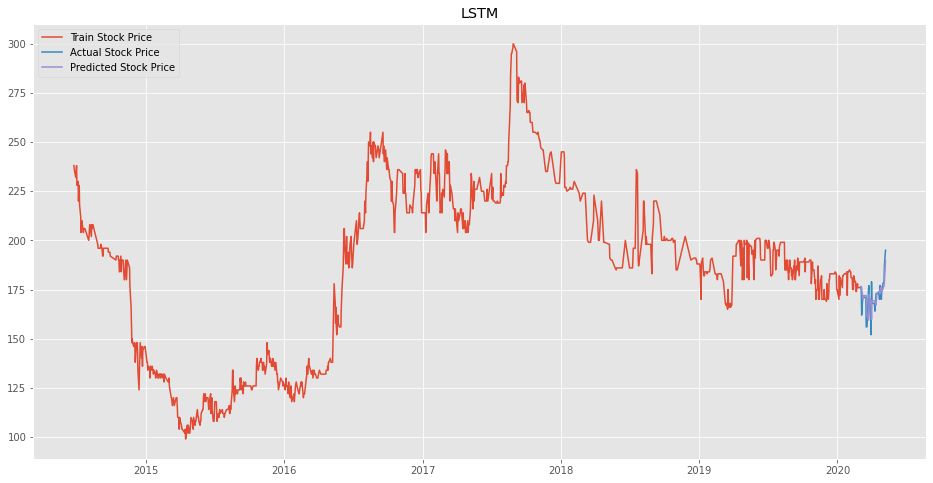

In [ ]:
test['PredClose'] = lstmModel_predictions
plt.figure(figsize=(16,8))
plt.plot(train['Close'], label = "Train Stock Price")
plt.plot(test['Close'], label = "Actual Stock Price")
plt.plot(test['PredClose'], label = "Predicted Stock Price")
plt.title("LSTM")
plt.legend(loc='upper left')
plt.show()

In [ ]:
mae = mean_absolute_error(test, lstmModel_predictions)
mape = np.mean(np.abs((test, lstmModel_predictions) / test)) * 100
mse = mean_squared_error(test, lstmModel_predictions)
rmse = np.sqrt(mean_squared_error(test, lstmModel_predictions))

print(f'The Mean Absolute Error (MAE) for LSTM is {mae}')
print(f'The Mean Absolute Percentage Error (MAPE) for LSTM is {mape}')
print(f'The Mean Squared Error (MSE) for LSTM is {mse}')
print(f'The Root Mean Square Error (RMSE) for LSTM is {rmse}')